## Feed Forward Neural Network

In [ ]:

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import sys

In [4]:
# Data Load

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = '/content/drive/Shareddrives/EEE405 Group Project/MagnetChallenge/data'
else:
    data_dir = 'C:/Users/moyin/Desktop/N87'

import os
import pandas as pd
import numpy as np

def load_material_data(material, data_dir=data_dir, first_row=0, last_row=None):
    """
    Load the material data from the data directory.
    :return: dict of pandas dataframes
    """
    material_dir = os.path.join(data_dir, material + "_cycle")
    if last_row is not None:
        nrows = last_row - first_row + 1
    else:
        nrows = None

    return {
        "Freq": pd.read_csv(os.path.join(material_dir, "Frequency[Hz].csv"), nrows=nrows, header=None, skiprows=first_row),
        "Temp": pd.read_csv(os.path.join(material_dir, "Temperature[C].csv"), nrows=nrows, header=None, skiprows=first_row),
        "B": pd.read_csv(os.path.join(material_dir, "B_waveform[T].csv"), header=None, nrows=nrows, skiprows=first_row),
        "H": pd.read_csv(os.path.join(material_dir, "H_waveform[Am-1].csv"), header=None, nrows=nrows, skiprows=first_row),
        "Loss": pd.read_csv(os.path.join(material_dir, "Volumetric_losses[Wm-3].csv"), header=None, nrows=nrows, names=["Loss"], skiprows=first_row),
    }

# Load data for different waveforms
# sine(0,337) triangle(338,3649) trap(3650,10151)
dfs = load_material_data("N87", first_row=0, last_row=10151)
dfs["Bpk"] = dfs["B"].max(axis=1)
def EstimateTriangleDuty(B):
    """Estimate the duty cycle of the triangle wave based on the index of the peak value"""
    Bpk = B.idxmax()
    return 100 * Bpk / len(B)
dfs["Duty"] = dfs["B"].apply(EstimateTriangleDuty, axis=1)

X = np.column_stack(
    (
        np.log10(dfs["Freq"].to_numpy()),
        np.log10(dfs["Bpk"].to_numpy()),
        dfs["Duty"]
    )
)
y = np.log10(dfs["Loss"].to_numpy())



In [5]:


# X and y input features and target labels
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1) # reshape for the output layer

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create a dataset and data loader
dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [26]:
# Define the neural network architecture
class MagneticLossPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(MagneticLossPredictor, self).__init__()
        # Define the first hidden layer with 5 neurons
        self.fc1 = nn.Linear(input_size, 4)
        # Define the second hidden layer with 8 neuron
        self.fc2 = nn.Linear(4, 36)
        # Define the third hidden layer with 5 neurons
        self.fc3 = nn.Linear(36, 21)
        # Define the output layer
        self.fc4 = nn.Linear(21, output_size)

    def forward(self, x):
        # Pass the input through the first hidden layer and apply the ReLU activation function
        x = torch.relu(self.fc1(x))
        # Pass the output of the first layer to the second hidden layer and apply ReLU
        x = torch.relu(self.fc2(x))
        # Pass the output of the second layer to the third hidden layer and apply ReLU
        x = torch.relu(self.fc3(x))
        # Pass the output of the third layer to the output layer
        x = self.fc4(x)
        return x

# Create the model
model = MagneticLossPredictor(input_size=3, output_size=1)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)

# Function to calculate the relative errors
def RelativeError(y_test, y_pred):
    AvgRPE = 100 * (torch.abs(y_test - y_pred) / y_test).mean().item()
    MaxRPE = 100 * (torch.abs(y_test - y_pred) / y_test).max().item()
    return AvgRPE, MaxRPE


num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        # Concatenate all batches
        predictions, actuals = torch.tensor([]), torch.tensor([])
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions = torch.cat((predictions, outputs), 0)
            actuals = torch.cat((actuals, targets), 0)

        # Calculate relative errors
        avg_rpe, max_rpe = RelativeError(actuals, predictions)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Avg RPE: {avg_rpe:.2f}%, Max RPE: {max_rpe:.2f}%')

Epoch [1/100], Loss: 0.2489, Avg RPE: 8.81%, Max RPE: 37.48%
Epoch [2/100], Loss: 0.0232, Avg RPE: 1.85%, Max RPE: 13.31%
Epoch [3/100], Loss: 0.0298, Avg RPE: 2.19%, Max RPE: 14.86%
Epoch [4/100], Loss: 0.0244, Avg RPE: 1.54%, Max RPE: 12.35%
Epoch [5/100], Loss: 0.0187, Avg RPE: 1.78%, Max RPE: 10.79%
Epoch [6/100], Loss: 0.0081, Avg RPE: 1.92%, Max RPE: 15.01%
Epoch [7/100], Loss: 0.0249, Avg RPE: 1.88%, Max RPE: 9.88%
Epoch [8/100], Loss: 0.0050, Avg RPE: 1.54%, Max RPE: 10.18%
Epoch [9/100], Loss: 0.0109, Avg RPE: 1.51%, Max RPE: 10.07%
Epoch [10/100], Loss: 0.0032, Avg RPE: 1.58%, Max RPE: 11.02%
Epoch [11/100], Loss: 0.0050, Avg RPE: 2.97%, Max RPE: 12.95%
Epoch [12/100], Loss: 0.0143, Avg RPE: 2.17%, Max RPE: 10.18%
Epoch [13/100], Loss: 0.0066, Avg RPE: 1.70%, Max RPE: 10.11%
Epoch [14/100], Loss: 0.0211, Avg RPE: 2.07%, Max RPE: 10.63%
Epoch [15/100], Loss: 0.0078, Avg RPE: 1.88%, Max RPE: 9.66%
Epoch [16/100], Loss: 0.0058, Avg RPE: 1.55%, Max RPE: 9.21%
Epoch [17/100], Loss

In [27]:
torch.save(model.state_dict(), 'trained_modelupdated.pth')

In [28]:
loaded_model = MagneticLossPredictor(input_size=3, output_size=1)
loaded_model.load_state_dict(torch.load('trained_modelupdated.pth'))
loaded_model.eval()

MagneticLossPredictor(
  (fc1): Linear(in_features=3, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=36, bias=True)
  (fc3): Linear(in_features=36, out_features=21, bias=True)
  (fc4): Linear(in_features=21, out_features=1, bias=True)
)

In [29]:
# Function to calculate the relative errors
def RelativeError(y_test, y_pred):
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
    
    AvgRPE = 100 * (torch.abs(y_test_tensor - y_pred_tensor) / y_test_tensor).mean().item()
    MaxRPE = 100 * (torch.abs(y_test_tensor - y_pred_tensor) / y_test_tensor).max().item()
    return AvgRPE, MaxRPE


loaded_model = MagneticLossPredictor(input_size=3, output_size=1)
loaded_model.load_state_dict(torch.load('trained_modelupdated.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Load the data for sine_dfs
sine_dfs = load_material_data("N87", first_row=0, last_row=337)
sine_dfs["Bpk"] = sine_dfs["B"].max(axis=1)
sine_dfs["Duty"] = sine_dfs["B"].apply(EstimateTriangleDuty, axis=1)

# Prepare the input features (X) for prediction
X_sine = np.column_stack(
    (
        np.log10(sine_dfs["Freq"].to_numpy()),
        np.log10(sine_dfs["Bpk"].to_numpy()),
        sine_dfs["Duty"]
    )
)
X_sine_tensor = torch.tensor(X_sine, dtype=torch.float32)

# Make predictions
with torch.no_grad():
    predictions_sine = loaded_model(X_sine_tensor)


y_test_sine = np.log10(sine_dfs["Loss"].to_numpy())

# Calculate relative errors
avg_rpe_sine, max_rpe_sine = RelativeError(y_test_sine, predictions_sine.numpy())

# Print or use the relative errors as needed
print(f'Avg RPE for sine_dfs: {avg_rpe_sine:.2f}%, Max RPE for sine_dfs: {max_rpe_sine:.2f}%')



Avg RPE for sine_dfs: 1.51%, Max RPE for sine_dfs: 4.40%


In [30]:
trap_dfs = load_material_data("N87", first_row=3650, last_row=10151)
trap_dfs["Bpk"] = trap_dfs["B"].max(axis=1)
trap_dfs["Duty"] = trap_dfs["B"].apply(EstimateTriangleDuty, axis=1)

# Prepare the input features (X) for prediction
X_trap = np.column_stack(
    (
        np.log10(trap_dfs["Freq"].to_numpy()),
        np.log10(trap_dfs["Bpk"].to_numpy()),
        trap_dfs["Duty"]
    )
)
X_trap_tensor = torch.tensor(X_trap, dtype=torch.float32)

# Make predictions
with torch.no_grad():
    predictions_trap = loaded_model(X_trap_tensor)

# The 'predictions_trap' tensor now contains the model's predictions for the trap_dfs data

# Assuming y_test is the ground truth for trap_dfs
y_test_trap = np.log10(trap_dfs["Loss"].to_numpy())

# Calculate relative errors
avg_rpe_trap, max_rpe_trap = RelativeError(y_test_trap, predictions_trap.numpy())

# Print or use the relative errors as needed
print(f'Avg RPE for trap_dfs: {avg_rpe_trap:.2f}%, Max RPE for trap_dfs: {max_rpe_trap:.2f}%')


Avg RPE for trap_dfs: 1.36%, Max RPE for trap_dfs: 8.19%


In [31]:
triangle_dfs = load_material_data("N87", first_row=338, last_row=3649)
triangle_dfs["Bpk"] = triangle_dfs["B"].max(axis=1)
triangle_dfs["Duty"] = triangle_dfs["B"].apply(EstimateTriangleDuty, axis=1)

# Prepare the input features (X) for prediction
X_triangle = np.column_stack(
    (
        np.log10(triangle_dfs["Freq"].to_numpy()),
        np.log10(triangle_dfs["Bpk"].to_numpy()),
        triangle_dfs["Duty"]
    )
)
X_triangle_tensor = torch.tensor(X_triangle, dtype=torch.float32)

# Make predictions
with torch.no_grad():
    predictions_triangle = loaded_model(X_triangle_tensor)



y_test_triangle = np.log10(triangle_dfs["Loss"].to_numpy())

# Calculate relative errors
avg_rpe_triangle, max_rpe_triangle = RelativeError(y_test_triangle, predictions_triangle.numpy())

# Print or use the relative errors as needed
print(f'Avg RPE for triangle_dfs: {avg_rpe_triangle:.2f}%, Max RPE for triangle_dfs: {max_rpe_triangle:.2f}%')

Avg RPE for triangle_dfs: 1.41%, Max RPE for triangle_dfs: 11.46%


In [32]:
results_table = pd.DataFrame({
    'Dataset': ['sine_dfs', 'triangle_dfs', 'trap_dfs'],
    'AvgRPE': [f'{avg_rpe_sine:.2f}%', f'{avg_rpe_triangle:.2f}%', f'{avg_rpe_trap:.2f}%'],
    'MaxRPE': [f'{max_rpe_sine:.2f}%', f'{max_rpe_triangle:.2f}%', f'{max_rpe_trap:.2f}%']
})

In [33]:
print("Results Table for N87 in percentage:")
results_table

Results Table for N87 in percentage:


,Dataset,AvgRPE,MaxRPE
0,sine_dfs,1.51%,4.40%
1,triangle_dfs,1.41%,11.46%
2,trap_dfs,1.36%,8.19%


In [34]:
import openpyxl
results_table.style.background_gradient(axis=None, low=0.75, high=1.0).to_excel("FNN.xlsx")

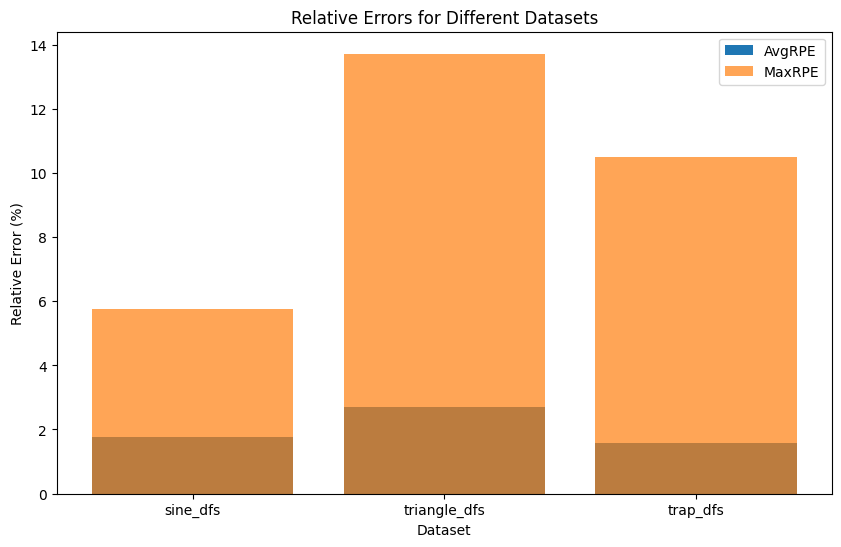

In [30]:
import matplotlib.pyplot as plt
# Visualize the results
plt.figure(figsize=(10, 6))
plt.bar(results_table['Dataset'], results_table['AvgRPE'].str.rstrip('%').astype('float'), label='AvgRPE')
plt.bar(results_table['Dataset'], results_table['MaxRPE'].str.rstrip('%').astype('float'), label='MaxRPE', alpha=0.7)
plt.title('Relative Errors for Different Datasets')
plt.xlabel('Dataset')
plt.ylabel('Relative Error (%)')
plt.legend()
plt.show()

## OPTUNA

In [25]:
import optuna

def objective(trial):
    # Define the hyperparameters to be optimized
    hidden_layer1_size = trial.suggest_int('hidden_layer1_size', 2, 50)
    hidden_layer2_size = trial.suggest_int('hidden_layer2_size', 2, 50)
    hidden_layer3_size = trial.suggest_int('hidden_layer3_size', 2, 50)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1,log=True)

    # Modify the model architecture based on the sampled hyperparameters
    model = MagneticLossPredictor(input_size=3, output_size=1)
    
    # Adjust the architecture based on the sampled hyperparameters
    model.fc1 = nn.Linear(3, hidden_layer1_size)
    model.fc2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)
    model.fc3 = nn.Linear(hidden_layer2_size, hidden_layer3_size)
    model.fc4 = nn.Linear(hidden_layer3_size, 1)

    # Define the loss function and the optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 50

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        predictions, actuals = torch.tensor([]), torch.tensor([])
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions = torch.cat((predictions, outputs), 0)
            actuals = torch.cat((actuals, targets), 0)

        # Calculate mean squared error (you can modify this to any metric you want to minimize)
        mse_loss = criterion(predictions, actuals)

    return mse_loss.item()

# Rest of the code remains the same
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-11-29 10:50:07,757] A new study created in memory with name: no-name-ea9aa218-929a-4368-a42b-f5ec8f81ccf8
[I 2023-11-29 10:50:35,523] Trial 0 finished with value: 0.4588407874107361 and parameters: {'hidden_layer1_size': 38, 'hidden_layer2_size': 38, 'hidden_layer3_size': 11, 'learning_rate': 2.6226151824229484e-05}. Best is trial 0 with value: 0.4588407874107361.
[I 2023-11-29 10:51:25,083] Trial 1 finished with value: 0.014299485832452774 and parameters: {'hidden_layer1_size': 47, 'hidden_layer2_size': 48, 'hidden_layer3_size': 9, 'learning_rate': 0.03434194087340384}. Best is trial 1 with value: 0.014299485832452774.
[I 2023-11-29 10:52:25,863] Trial 2 finished with value: 0.008214987814426422 and parameters: {'hidden_layer1_size': 46, 'hidden_layer2_size': 49, 'hidden_layer3_size': 34, 'learning_rate': 0.00023418526219720745}. Best is trial 2 with value: 0.008214987814426422.
[I 2023-11-29 10:52:57,708] Trial 3 finished with value: 0.0069025177508592606 and parameters: {'hi

Number of finished trials: 50
Best trial:
Value:  0.006784788332879543
Params: 
    hidden_layer1_size: 4
    hidden_layer2_size: 36
    hidden_layer3_size: 21
    learning_rate: 0.004106430533358525
